## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  
c

{'bias': 0.0,
 'case': 'local',
 'colors': [['tab:blue', 'lightblue'],
  ['tab:orange', 'lightorange'],
  ['tab:red', 'red'],
  ['tab:green', 'lightgreen']],
 'corrlength': 2,
 'figformat': 'pdf',
 'livetime': 2.154434690031884,
 'livetimes': [0.01,
  0.021544346900318832,
  0.046415888336127774,
  0.1,
  0.21544346900318834,
  0.46415888336127775,
  1.0,
  2.154434690031884,
  4.641588833612778,
  10.0,
  21.544346900318832,
  46.41588833612777,
  100.0],
 'local': {'path': '/home/katrin/Documents',
  'path_pksflare': '/home/katrin/Documents/nuisance_summary/PKS_flare'},
 'magnitude': 10,
 'model': 'crab_cutoff',
 'norm': 0.0,
 'parameter_names': [['amplitude', 'index'],
  ['amplitude', 'lambda_'],
  ['lambda_', 'index']],
 'resolution': 0,
 'source': 'PKSflare',
 'sys': 'Bkgext',
 'tilt': 0.0,
 'wecap': {'path': '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset',
  'path_pksflare': '/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare'},
 'woody': {'

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(sys)

2.154434690031884
Bkgext


In [4]:
c['model']

'crab_cutoff'

In [5]:
%%time
amplitude= Parameter('amplitude', value = 3.85e-12, unit=u.Unit("1 / (TeV s cm2)"))
dataset_input_point  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = [amplitude],
                                           spatial_model =None)
from gammapy.modeling.models import GaussianSpatialModel
gaussian = GaussianSpatialModel(lon_0 = dataset_input_point.models.parameters['lon_0'],
                                lat_0 = dataset_input_point.models.parameters['lat_0'],
                                sigma = 0.3 *u.deg
                               )


dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = [amplitude],
                                           spatial_model =gaussian)


loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
loaded dataset:
/home/katrin/Documents/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 10.4 s, sys: 578 ms, total: 11 s
Wall time: 11 s


<WCSAxes: >

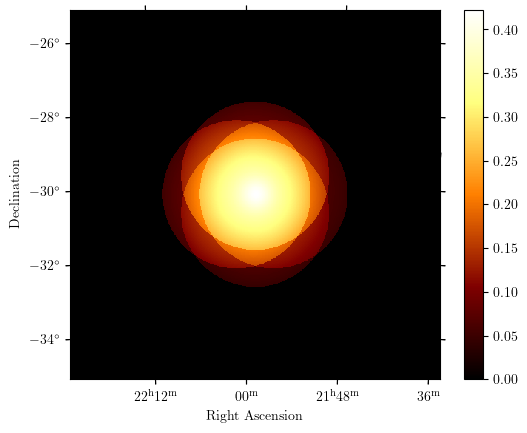

In [6]:
dataset_input.npred().sum_over_axes().plot(add_cbar =1)

In [7]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if "Bkg" in sys or "BKG" in sys:

    # piece wise model
    # remove old bkg model
    setup.set_up_bkg_sys_V( breake = 10,
                        index1 = 2,
                        index2 = 1.5, 
                        magnitude = magnitude )

    dataset_asimov, dataset_asimov_N = setup.run()

    #setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    #setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    #setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)

In [8]:
%%time
fitting = 0
if fitting:
    fit_cor = Fit(store_trace=0)
    minuit_opts = {"tol": 0.1, "strategy": 2}
    fit_cor.backend = "minuit"
    fit_cor.optimize_opts = minuit_opts
    result_cor = fit_cor.run(dataset_asimov)
    print(result_cor)
    print("saving")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models.write(path,overwrite=True)
    
    
else:
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    print(path[:-4])
    cov = dataset_asimov.models.read_covariance(path = path[:-4]+"_covariance.dat", filename = "",
                                            format="ascii.fixed_width")


../Bkgext_PKSflare_crab_cutoff/data/0_model_livetime_2.154434690031884
CPU times: user 21.8 ms, sys: 942 µs, total: 22.7 ms
Wall time: 21.3 ms


In [9]:
print(dataset_asimov_N)

MapDataset
----------

  Name                            : dataset_N 

  Total counts                    : 661 
  Total background counts         : 8902.95
  Total excess counts             : -8241.47

  Predicted counts                : 87.31
  Predicted background counts     : 0.00
  Predicted excess counts         : 87.31

  Exposure min                    : 3.39e-27 m2 s
  Exposure max                    : 2.74e+09 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 942469 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 19561.90

  Number of models                : 2 
  Number of parameters            : 35
  Number of free parameters       : 26

  Component 0: SkyModel
  
    Name                      : Crablog
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
      i

In [10]:
%%time
fitting = 1
if fitting:
    fit_cor = Fit(store_trace=0)
    result_cor = fit_cor.run(dataset_asimov_N)
    print(result_cor)
    print("saving")
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N.models.write(path,overwrite=True)
    
    
else:
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N.models = Models.read(path)


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : False
	message    : Optimization failed. Call limit was reached.
	nfev       : 6201
	total stat : 17484.33

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

saving
CPU times: user 5min 42s, sys: 37.8 s, total: 6min 20s
Wall time: 6min 20s


In [11]:
print(dataset_asimov_N.background_model)

FoVBackgroundModel

  Name                      : dataset_N-bkg
  Datasets names            : ['dataset_N']
  Spectral model type       : PiecewiseNormSpectralModel
  Parameters:
    _norm      (frozen)        :      0.000                  
    norm0      (frozen)        :      0.000                  
    norm1      (frozen)        :      0.000                  
    norm2      (frozen)        :      0.000                  
    norm3      (frozen)        :      0.000                  
    norm4                      :      0.000  +/-    0.00             
    norm5                      :      0.000  +/-    0.00             
    norm6                      :      0.000  +/-    0.00             
    norm7                      :      0.000  +/-    0.00             
    norm8                      :      0.000  +/-    0.00             
    norm9                      :      0.000  +/-    0.00             
    norm10                     :      0.000  +/-    0.00             
    norm11           

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.45205923e-14  3.41473495e-09  5.47135914e-17
  5.58246498e-20  5.97946923e-21  6.07942959e-21  3.41522327e-22
  1.26229574e-20  1.47131025e-20  2.74392243e-20 -4.96174196e-09
  1.91287133e-20  3.26587317e-20  4.06085013e-20  6.02149274e-20
  2.00968219e-19  1.01134238e-19  1.81014256e-19  3.37743144e-19
  4.76496480e-19]


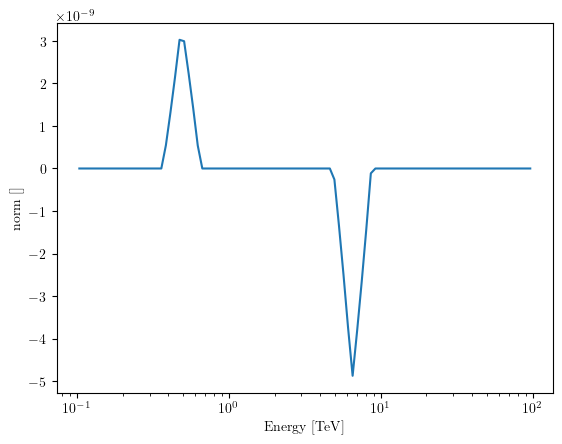

In [12]:
ax = dataset_asimov_N.background_model.spectral_model.plot()
ax.set_yscale("linear")
print(dataset_asimov_N.background_model.spectral_model.parameters.value)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e-12 1.00000026e-12 1.00002047e-12 1.00126642e-12
 1.06101937e-12 3.28973485e-12 6.79158609e-11 1.52399797e-09
 2.69967850e-08 3.72666317e-07 4.00653074e-06 3.35462638e-05
 2.18749113e-04 1.11089965e-03 4.39369336e-03 1.35335283e-02
 3.24652467e-02 6.06530660e-02 8.82496903e-02 1.00000000e-01]


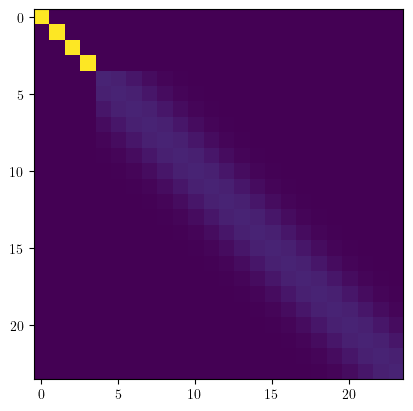

In [13]:
from Dataset_Setup import GaussianCovariance_matrix
cov = GaussianCovariance_matrix(size = len(setup.emask()),
                                        magnitude = magnitude, 
                                        corrlength = corrlength)
plt.imshow(cov.cov())
print(cov.cov()[-1])

In [14]:
plt.imshow(dataset_asimov_N.background_model.spectral_model.parameters.prior[1].covariance_matrix)

AttributeError: 'NoneType' object has no attribute 'covariance_matrix'

In [17]:
dataset_asimov_N.background_model.spectral_model.parameters.value  = setup.dataset_helper.background_model.spectral_model.parameters.value



In [20]:
dataset_asimov_N.background_model.spectral_model

shift 1.0
shift 1.0


<Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>

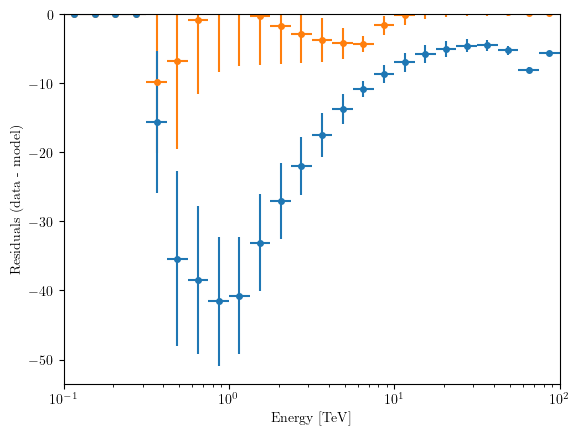

In [21]:
ax = dataset_asimov.plot_residuals_spectral(color = 'tab:orange')
dataset_asimov_N.plot_residuals_spectral(ax = ax, color = 'tab:blue')

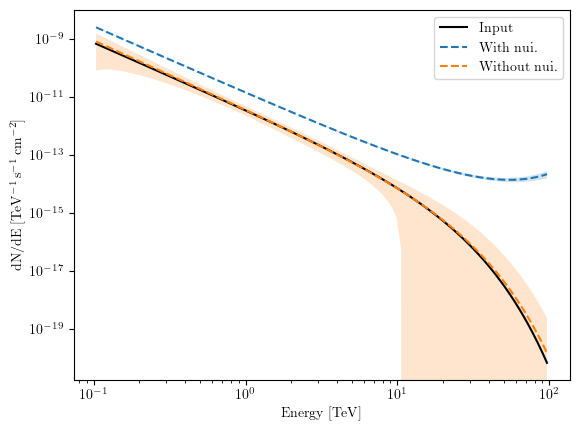

In [15]:

ax = dataset_input.models[0].spectral_model.plot(color = 'black', label = 'Input')
dataset_asimov_N.models[0].spectral_model.plot(color = 'tab:blue', linestyle = 'dashed',
                                                 label = "With nui.")
dataset_asimov_N.models[0].spectral_model.plot_error(ax = ax, facecolor = 'tab:blue')

dataset_asimov.models[0].spectral_model.plot(color = 'tab:orange', linestyle = 'dashed',
                                                 label = "Without nui.")
dataset_asimov.models[0].spectral_model.plot_error(ax = ax, facecolor = 'tab:orange')



ax.legend()

In [ ]:
print(dataset_asimov.models[0])

In [ ]:


ax = dataset_asimov_N.background_model.spectral_model.plot()
setup.dataset_helper.background_model.spectral_model.plot()
ax.set_yscale("linear")
print(dataset_asimov_N.background_model.spectral_model.parameters.value)

In [ ]:
setup.dataset_helper.background_model